In [17]:
# -*- coding: utf-8 -*- #

# Write libraries here #########################################
import matplotlib.patches as pat
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from astropy import units as u
from astropy.cosmology import WMAP9 as cosmo
from astroquery.gama import GAMA
from jupyterthemes import jtplot
from mpl_toolkits.mplot3d import Axes3D
from sklearn import manifold, cluster, preprocessing, mixture
from time import time
from tqdm import tnrange, tqdm_notebook
%matplotlib inline
################################################################


# Showing 500 columns and rows #################################
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
################################################################


# NOT CHANGE (The PATH for directory) ##########################
CURRENT_DIR_NAME = os.path.dirname(os.path.abspath(__name__))
PATH_DATA = os.path.join(CURRENT_DIR_NAME, '../data/')
PATH_HIST = os.path.join(CURRENT_DIR_NAME, '../histogram/')
PATH_PLOT = os.path.join(CURRENT_DIR_NAME, '../plots/')
PATH_IMG = os.path.join(CURRENT_DIR_NAME, '../images/')
PATH_HTML = os.path.join(CURRENT_DIR_NAME, '../html/')
PATH_TEX = os.path.join(CURRENT_DIR_NAME, '../for_tex/')
################################################################

#When you make plots, jtplot is better.
jtplot.style(theme='grade3', context='notebook', fscale=3, spines=True, gridlines='--', ticks=False, grid=False)

In [2]:
# Read the data

DATA_GAMA_KCORRECTED = GAMA.query_sql('SELECT * FROM kcorr_auto_z00 LIMIT 1000000')
#DATA_GAMA_MAGPHYS = GAMA.query_sql('SELECT * FROM MagPhys LIMIT 1000000')
DATA_GAMA_FLUX = GAMA.query_sql('SELECT * FROM LambdarCat LIMIT 1000000')
#DATA_GAMA_REDSHIFT = GAMA.query_sql('SELECT * FROM AATRunzResults LIMIT 1000000')

${\rm m}_{\rm AB,\,band} = {\rm M}_{\rm AB,\,band} + 5\log\left(\frac{D_L}{10\,[{\rm pc}]}\right) + K_{\rm band}$ ($D_L$ : Luminosity Distance)
${\rm m}_{\rm AB,\,band} = -2.5\log\left(\frac{f_{\rm band}}{[{\rm Jy}]}\right) + 8.90$

In [3]:
# Arrange the Astropy table for the analysis (Convert into pd.DataFrame, set index and select samples which have reliable redshift)
DATA_GAMA_FLUX = DATA_GAMA_FLUX.to_pandas().set_index('CATAID')
DATA_GAMA_KCORRECTED = DATA_GAMA_KCORRECTED.to_pandas().set_index('CATAID').loc[DATA_GAMA_KCORRECTED['NQ'] >= 3]
DATA_GAMA_FLUX = DATA_GAMA_FLUX.loc[(DATA_GAMA_FLUX['FUV_flux'] > 0) & (DATA_GAMA_FLUX['NUV_flux'] > 0) &
                                    (DATA_GAMA_FLUX['u_flux'] > 0) & (DATA_GAMA_FLUX['g_flux'] > 0) & (DATA_GAMA_FLUX['r_flux'] > 0) & (DATA_GAMA_FLUX['i_flux'] > 0) & (DATA_GAMA_FLUX['z_flux'] > 0) & 
                                    (DATA_GAMA_FLUX['Y_flux'] > 0) & (DATA_GAMA_FLUX['J_flux'] > 0) & (DATA_GAMA_FLUX['H_flux'] > 0) & (DATA_GAMA_FLUX['K_flux'] > 0)].join(DATA_GAMA_KCORRECTED, how='inner')
DATA_GAMA_FLUX['FUV_flux_kcorrected'] = -2.5 * np.log10(DATA_GAMA_FLUX['FUV_flux']) + 8.90 - DATA_GAMA_FLUX['KCORR_FUV'] - 5 * np.log10(cosmo.luminosity_distance(DATA_GAMA_FLUX['Z_TONRY']).to(u.parsec).value / 10)
DATA_GAMA_FLUX['NUV_flux_kcorrected'] = -2.5 * np.log10(DATA_GAMA_FLUX['NUV_flux']) + 8.90 - DATA_GAMA_FLUX['KCORR_NUV'] - 5 * np.log10(cosmo.luminosity_distance(DATA_GAMA_FLUX['Z_TONRY']).to(u.parsec).value / 10)
DATA_GAMA_FLUX['U_flux_kcorrected'] = -2.5 * np.log10(DATA_GAMA_FLUX['u_flux']) + 8.90 - DATA_GAMA_FLUX['KCORR_U'] - 5 * np.log10(cosmo.luminosity_distance(DATA_GAMA_FLUX['Z_TONRY']).to(u.parsec).value / 10)
DATA_GAMA_FLUX['G_flux_kcorrected'] = -2.5 * np.log10(DATA_GAMA_FLUX['g_flux']) + 8.90 - DATA_GAMA_FLUX['KCORR_G'] - 5 * np.log10(cosmo.luminosity_distance(DATA_GAMA_FLUX['Z_TONRY']).to(u.parsec).value / 10)
DATA_GAMA_FLUX['R_flux_kcorrected'] = -2.5 * np.log10(DATA_GAMA_FLUX['r_flux']) + 8.90 - DATA_GAMA_FLUX['KCORR_R'] - 5 * np.log10(cosmo.luminosity_distance(DATA_GAMA_FLUX['Z_TONRY']).to(u.parsec).value / 10)
DATA_GAMA_FLUX['I_flux_kcorrected'] = -2.5 * np.log10(DATA_GAMA_FLUX['i_flux']) + 8.90 - DATA_GAMA_FLUX['KCORR_I'] - 5 * np.log10(cosmo.luminosity_distance(DATA_GAMA_FLUX['Z_TONRY']).to(u.parsec).value / 10)
DATA_GAMA_FLUX['Z_flux_kcorrected'] = -2.5 * np.log10(DATA_GAMA_FLUX['z_flux']) + 8.90 - DATA_GAMA_FLUX['KCORR_Z'] - 5 * np.log10(cosmo.luminosity_distance(DATA_GAMA_FLUX['Z_TONRY']).to(u.parsec).value / 10)
DATA_GAMA_FLUX['Y_flux_kcorrected'] = -2.5 * np.log10(DATA_GAMA_FLUX['Y_flux']) + 8.90 - DATA_GAMA_FLUX['KCORR_Y'] - 5 * np.log10(cosmo.luminosity_distance(DATA_GAMA_FLUX['Z_TONRY']).to(u.parsec).value / 10)
DATA_GAMA_FLUX['J_flux_kcorrected'] = -2.5 * np.log10(DATA_GAMA_FLUX['J_flux']) + 8.90 - DATA_GAMA_FLUX['KCORR_J'] - 5 * np.log10(cosmo.luminosity_distance(DATA_GAMA_FLUX['Z_TONRY']).to(u.parsec).value / 10)
DATA_GAMA_FLUX['H_flux_kcorrected'] = -2.5 * np.log10(DATA_GAMA_FLUX['H_flux']) + 8.90 - DATA_GAMA_FLUX['KCORR_H'] - 5 * np.log10(cosmo.luminosity_distance(DATA_GAMA_FLUX['Z_TONRY']).to(u.parsec).value / 10)
DATA_GAMA_FLUX['K_flux_kcorrected'] = -2.5 * np.log10(DATA_GAMA_FLUX['K_flux']) + 8.90 - DATA_GAMA_FLUX['KCORR_K'] - 5 * np.log10(cosmo.luminosity_distance(DATA_GAMA_FLUX['Z_TONRY']).to(u.parsec).value / 10)
DATA_GAMA_FLUX['R-K'] = DATA_GAMA_FLUX['R_flux_kcorrected'] - DATA_GAMA_FLUX['K_flux_kcorrected']
DATA_GAMA_FLUX['NUV-R'] = DATA_GAMA_FLUX['NUV_flux_kcorrected'] - DATA_GAMA_FLUX['R_flux_kcorrected']
#DATA_GAMA_FLUX = DATA_GAMA_FLUX.loc[(DATA_GAMA_FLUX['NUV_flux_kcorrected'] < 23.5) & (DATA_GAMA_FLUX['I_flux_kcorrected'] < 22.5)]
#DATA_GAMA_FLUX = DATA_GAMA_FLUX.loc[(DATA_GAMA_FLUX['Z_TONRY'] < 0.4) & (DATA_GAMA_FLUX['NUV_flux_kcorrected'] < 23.5) & (DATA_GAMA_FLUX['I_flux_kcorrected'] < 22.5)]
DATA_GAMA_FLUX = DATA_GAMA_FLUX.loc[(DATA_GAMA_FLUX['FUV_flux_kcorrected'] >= -23.5) & (DATA_GAMA_FLUX['FUV_flux_kcorrected'] < -10.0) &
                                    (DATA_GAMA_FLUX['NUV_flux_kcorrected'] >= -23.5) & (DATA_GAMA_FLUX['NUV_flux_kcorrected'] < -10.0) &
                                    (DATA_GAMA_FLUX['U_flux_kcorrected'] >= -23.5) & (DATA_GAMA_FLUX['U_flux_kcorrected'] < -15.0) &
                                    (DATA_GAMA_FLUX['G_flux_kcorrected'] >= -23.5) & (DATA_GAMA_FLUX['G_flux_kcorrected'] < -15.0) &
                                    (DATA_GAMA_FLUX['R_flux_kcorrected'] >= -26.0) & (DATA_GAMA_FLUX['R_flux_kcorrected'] < -15.0) &
                                    (DATA_GAMA_FLUX['I_flux_kcorrected'] >= -26.0) & (DATA_GAMA_FLUX['I_flux_kcorrected'] < -15.0) &
                                    (DATA_GAMA_FLUX['Z_flux_kcorrected'] >= -26.0) & (DATA_GAMA_FLUX['Z_flux_kcorrected'] < -15.0) &
                                    (DATA_GAMA_FLUX['Y_flux_kcorrected'] >= -26.0) & (DATA_GAMA_FLUX['Y_flux_kcorrected'] < -15.0) &
                                    (DATA_GAMA_FLUX['J_flux_kcorrected'] >= -26.0) & (DATA_GAMA_FLUX['J_flux_kcorrected'] < -15.0) &
                                    (DATA_GAMA_FLUX['H_flux_kcorrected'] >= -26.0) & (DATA_GAMA_FLUX['H_flux_kcorrected'] < -15.0) &
                                    (DATA_GAMA_FLUX['K_flux_kcorrected'] >= -26.0) & (DATA_GAMA_FLUX['K_flux_kcorrected'] < -15.0)]
# Show the details of our samples for manifold learning
display(DATA_GAMA_FLUX.describe())

RA           DEC      FUV_flux   FUV_fluxerr      NUV_flux  \
count  73768.000000  73768.000000  7.376800e+04  7.376800e+04  7.376800e+04   
mean     189.651980      0.375954  9.691125e-06  1.433836e-06  1.771798e-05   
std       33.758608      1.356445  7.012375e-05  1.041517e-05  1.183519e-04   
min      129.000109     -2.993768  3.332060e-10  5.765690e-09  9.628900e-10   
25%      175.047449     -0.746373  1.254405e-06  6.841088e-07  4.301507e-06   
50%      212.479781      0.323242  3.529270e-06  8.983840e-07  9.155720e-06   
75%      217.577880      1.461775  8.657525e-06  1.233078e-06  1.696793e-05   
max      223.499878      2.999971  1.114510e-02  1.909930e-03  2.128940e-02   

        NUV_fluxerr        u_flux     u_fluxerr        g_flux     g_fluxerr  \
count  7.376800e+04  7.376800e+04  7.376800e+04  7.376800e+04  7.376800e+04   
mean   6.959949e-06  3.941530e-05  5.811074e-06  1.233047e-04  6.644793e-06   
std    7.378952e-05  3.199671e-04  2.849965e-05  1.023210e-03  2.587866e-05   
min    3.340650e-08  1.335430e-08  2.499510e-07  4.235320e-08  1.292490e-07   
25%    9.051390e-07  9.912963e-06  1.989115e-06  3.048285e-05  9.470705e-07   
50%    1.337930e-06  1.797575e-05  2.772085e-06  5.210875e-05  1.543505e-06   
75%    2.466845e-06  3.337297e-05  4.167825e-06  9.683630e-05  3.796227e-06   
max    8.833300e-03  5.932940e-02  1.740130e-03  1.802290e-01  1.697120e-03   

             r_flux     r_fluxerr        i_flux     i_fluxerr        z_flux  \
count  7.376800e+04  7.376800e+04  7.376800e+04  7.376800e+04  7.376800e+04   
mean   2.410331e-04  9.234676e-06  3.432591e-04  1.262331e-05  4.200821e-04   
std    1.833359e-03  3.051119e-05  2.540001e-03  3.919699e-05  3.083389e-03   
min    1.538570e-08  1.932670e-07  3.210630e-08  2.658190e-07  4.034540e-08   
25%    6.772207e-05  1.510898e-06  9.731525e-05  2.303157e-06  1.206148e-04   
50%    1.118075e-04  2.541675e-06  1.616545e-04  3.871210e-06  1.992710e-04   
75%    1.949315e-04  5.820015e-06  2.830255e-04  8.681093e-06  3.484990e-04   
max    3.142220e-01  2.135520e-03  4.250200e-01  2.806200e-03  5.119440e-01   

          z_fluxerr        X_flux     X_fluxerr        Y_flux     Y_fluxerr  \
count  7.376800e+04  73768.000000  73768.000000  7.376800e+04  73768.000000   
mean   2.667000e-05     -4.725897     -4.726298  5.097796e-04      0.000035   
std    9.312436e-05     68.551593     68.551566  3.493307e-03      0.000169   
min    9.431560e-07   -999.000000   -999.000000  1.016350e-07      0.000001   
25%    7.361505e-06      0.000121      0.000003  1.429553e-04      0.000006   
50%    1.091005e-05      0.000201      0.000006  2.402225e-04      0.000010   
75%    1.832998e-05      0.000351      0.000013  4.254310e-04      0.000021   
max    4.074100e-03      0.418524      0.003546  5.234810e-01      0.010409   

             J_flux     J_fluxerr        H_flux     H_fluxerr        K_flux  \
count  7.376800e+04  73768.000000  7.376800e+04  73768.000000  7.376800e+04   
mean   6.000265e-04      0.000032  7.329608e-04      0.000037  7.477631e-04   
std    4.066153e-03      0.000131  4.841449e-03      0.000115  4.133784e-03   
min    9.308100e-07      0.000001  7.511100e-07      0.000002  5.765860e-07   
25%    1.667140e-04      0.000006  2.051290e-04      0.000011  2.323077e-04   
50%    2.856250e-04      0.000010  3.538470e-04      0.000016  4.020560e-04   
75%    5.096573e-04      0.000021  6.330400e-04      0.000029  7.051335e-04   
max    6.192200e-01      0.008726  7.565100e-01      0.006519  6.328390e-01   

          K_fluxerr       W1_flux    W1_fluxerr       W2_flux    W2_fluxerr  \
count  73768.000000  73768.000000  73768.000000  7.376800e+04  73768.000000   
mean       0.000038      0.000396      0.000068  2.707400e-04      0.000066   
std        0.000131      0.002416      0.000197  1.440871e-03      0.000228   
min        0.000003      0.000000      0.000005 -5.913180e-09      0.000004   
25%        0.000011      0.000130      0.000039  9.226087e-05 

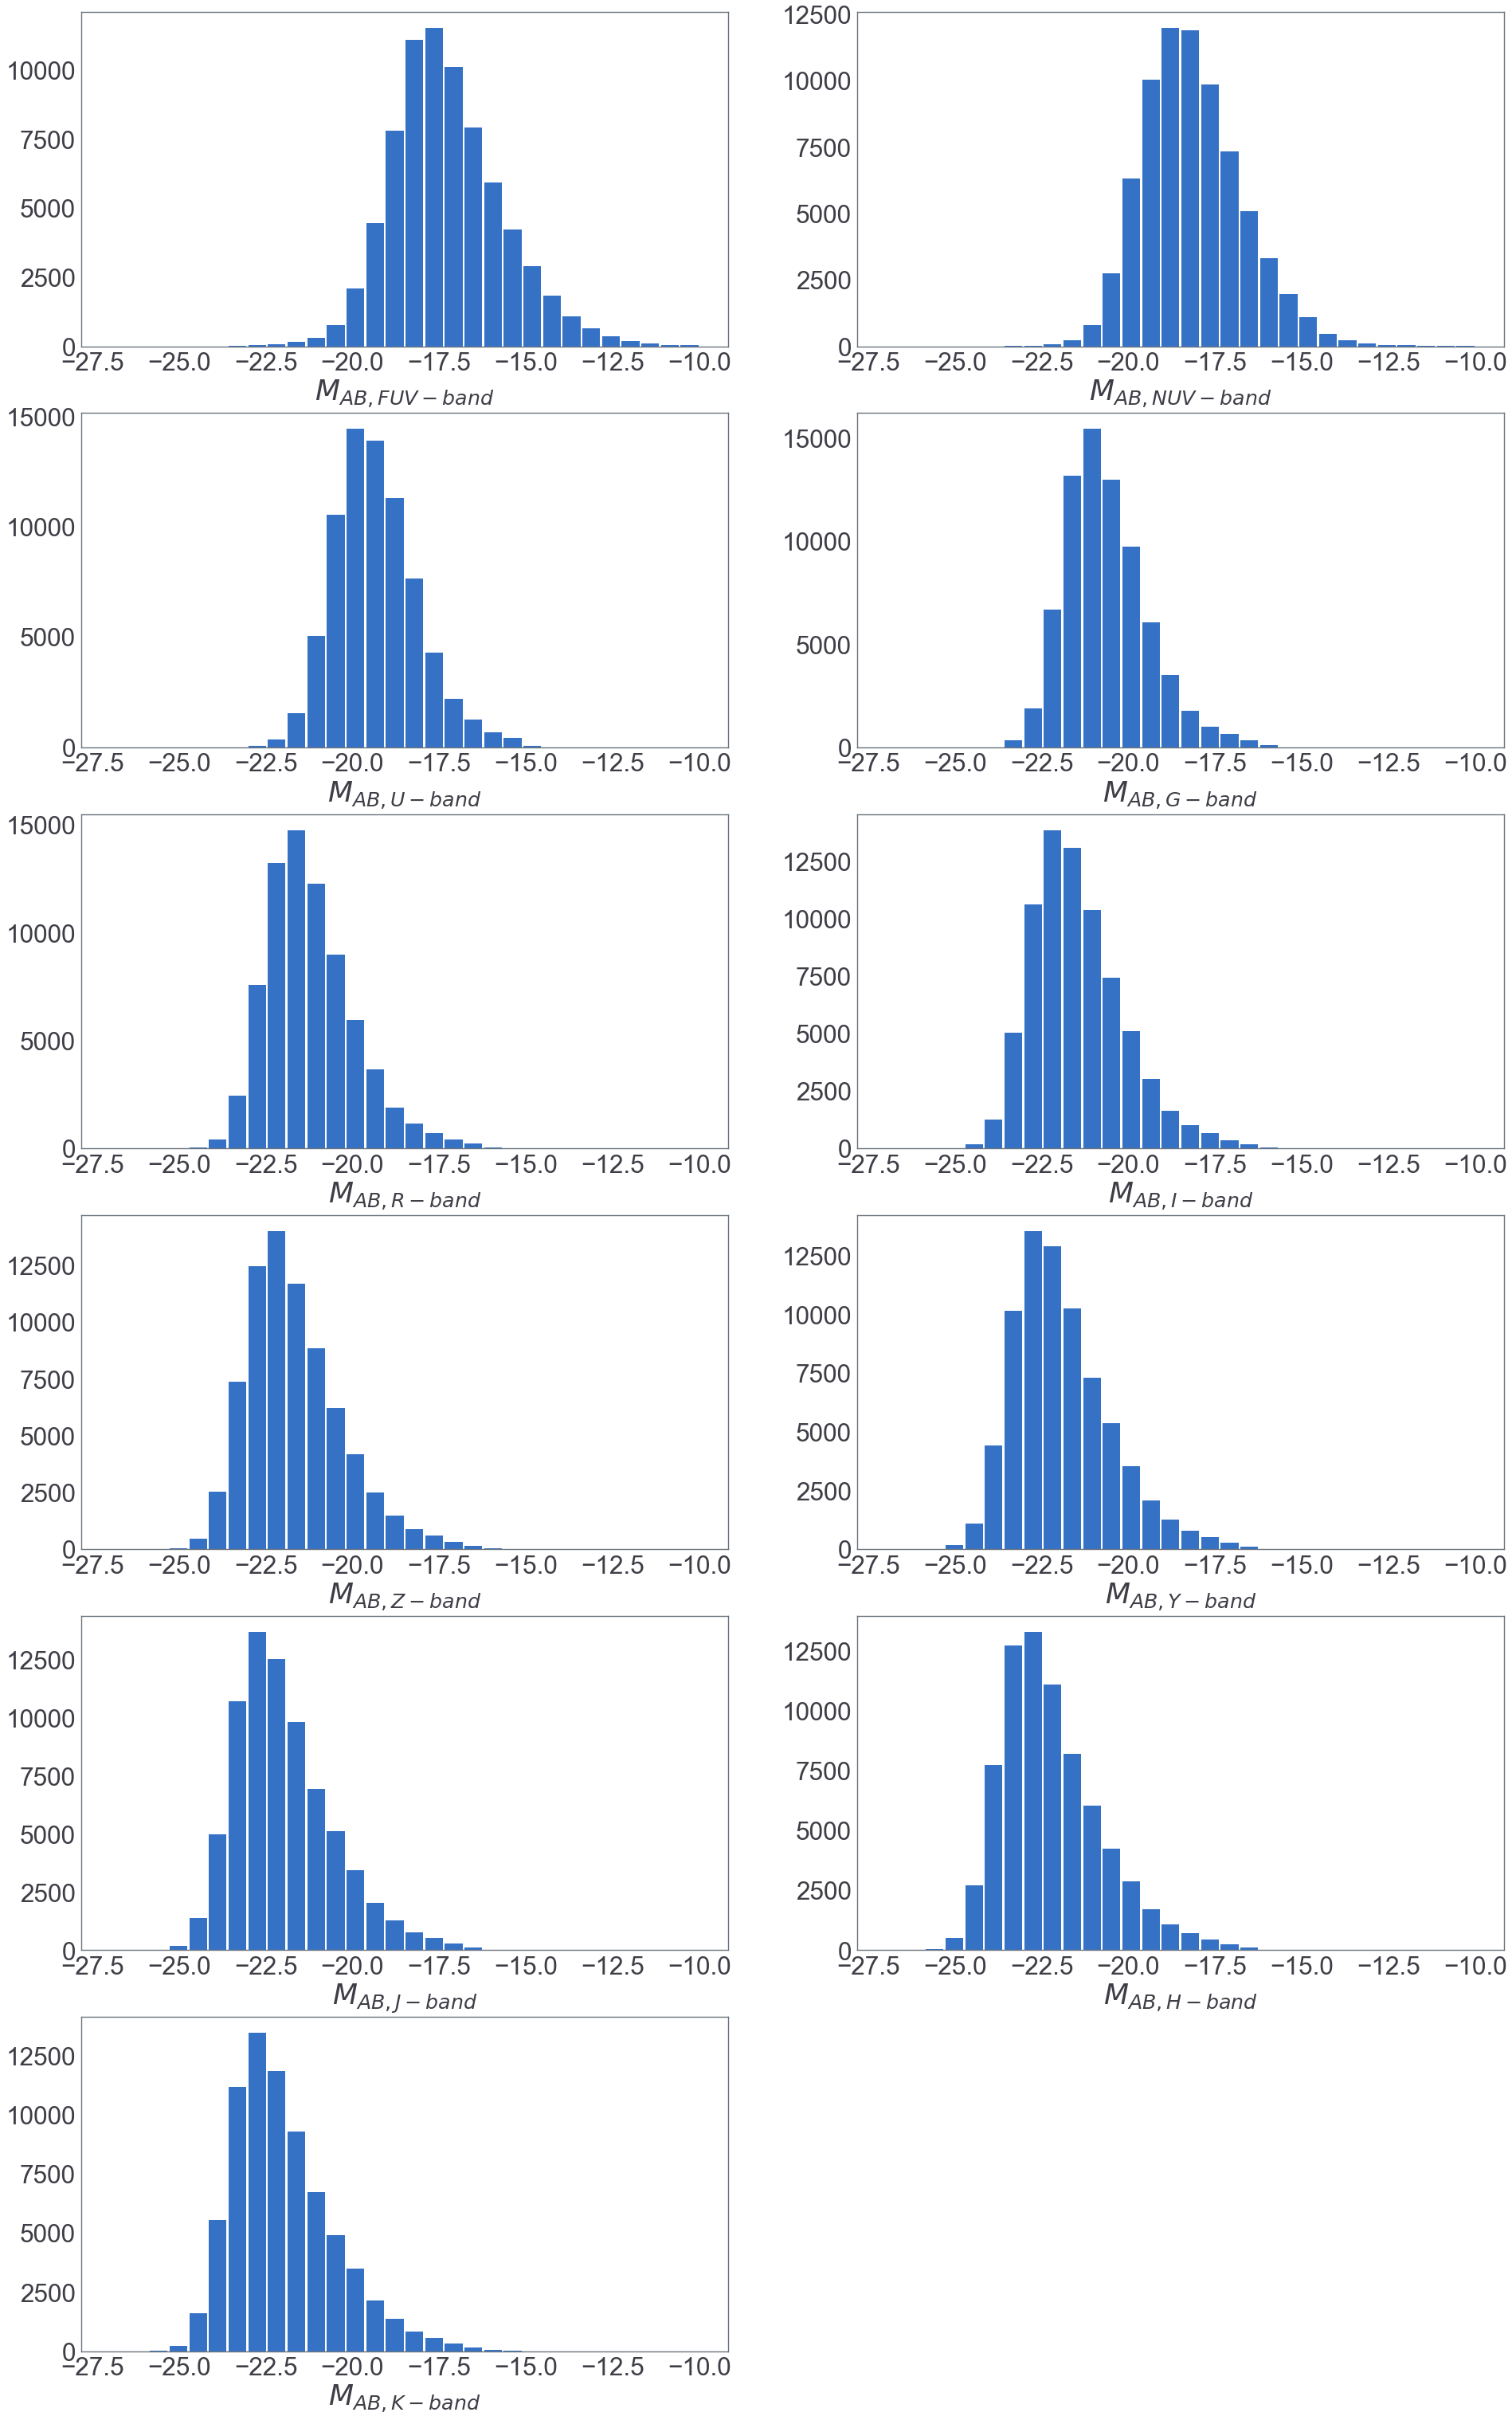

In [4]:
BANDS = ['FUV', 'NUV', 'U', 'G', 'R', 'I', 'Z', 'Y', 'J', 'H', 'K']
fig = plt.figure(figsize=(32, 54))
for i, band in tqdm_notebook(enumerate(BANDS)):
    ax = fig.add_subplot(6, 2, 1+i)
    ax.hist(DATA_GAMA_FLUX['%s_flux_kcorrected'%(band)], density=False, range=[-27, -10], bins=30,  rwidth=0.9)
    ax.set_xlabel(r'$M_{AB, %s-band}$'%(band))

## Show the distribution of redshift of our samples

# of samples = 73768


Text(0.5, 1.0, 'The redshift distribution of samples')

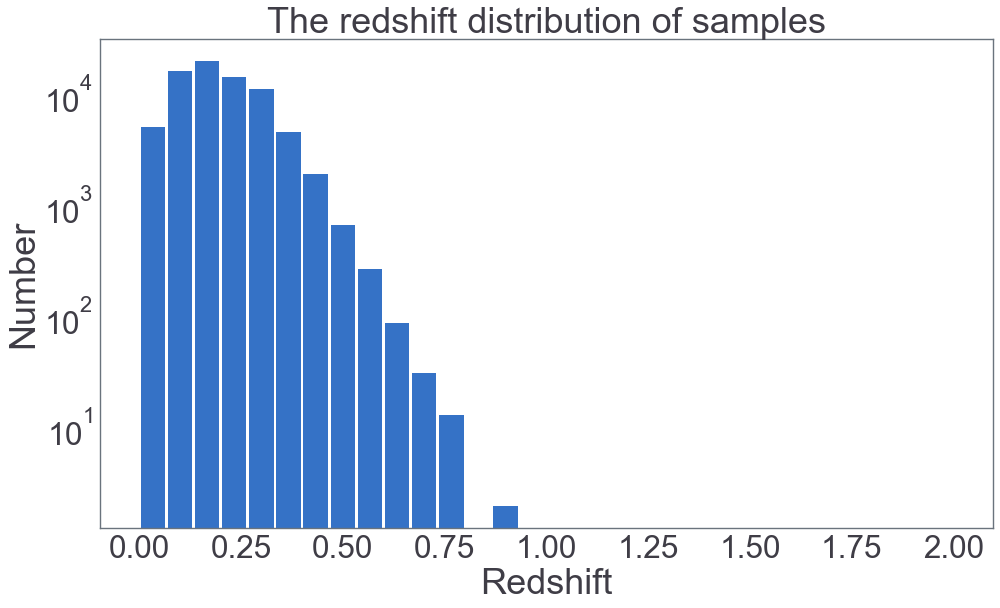

In [5]:

plt.figure(figsize=(16, 9))
plt.hist(DATA_GAMA_FLUX['Z_TONRY'], range=[0, 2], bins=30,  rwidth=0.9)
print('# of samples = %s'%(len(DATA_GAMA_FLUX['Z_TONRY'])))
plt.xlabel('Redshift')
plt.ylabel('Number')
plt.yscale('log')
plt.title('The redshift distribution of samples')


## Color-color plot (NUV-r and r-K)

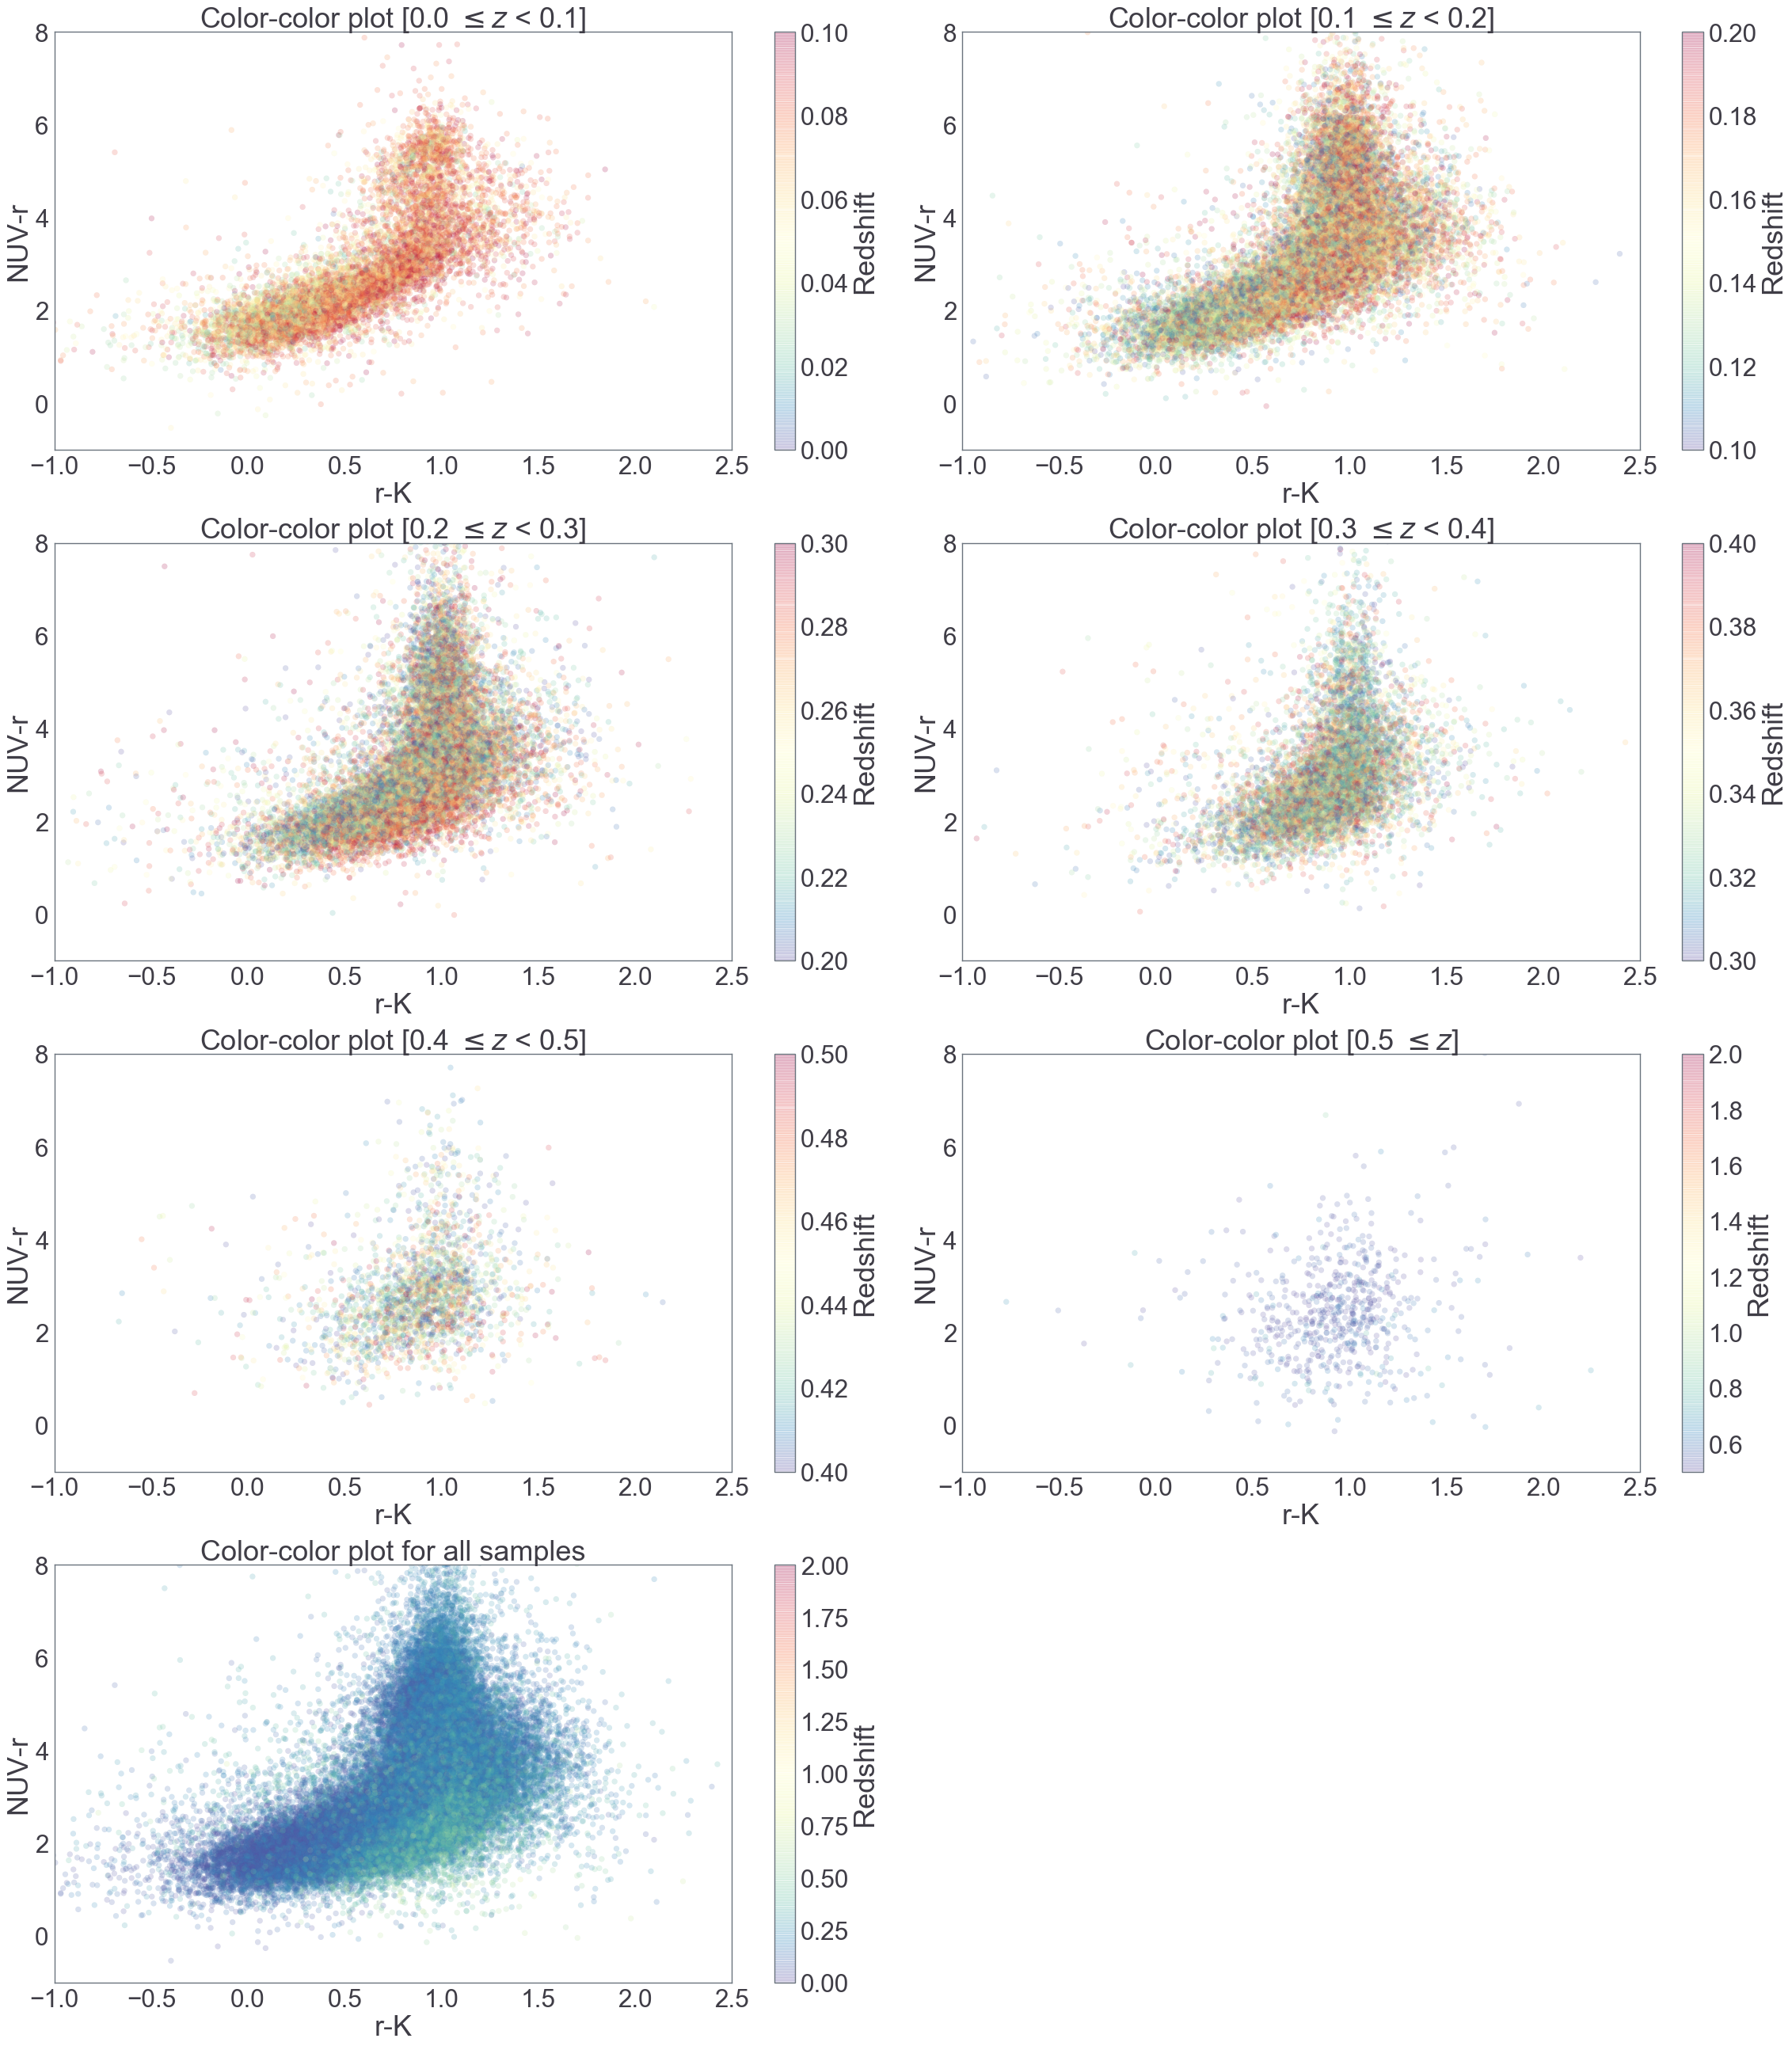

In [6]:
#  Color-color plot with colorbars based on redshift
plt.figure(figsize=(32, 36))
for i in tnrange(6):
    if i <= 4:
        plt.subplot(421 + i)
        z_range = (DATA_GAMA_FLUX['Z_TONRY'] >= 0.1 * i) & (DATA_GAMA_FLUX['Z_TONRY'] < (0.1 * i) + 0.1)
        x = DATA_GAMA_FLUX['R-K'].loc[z_range]
        y = DATA_GAMA_FLUX['NUV-R'].loc[z_range]
        c_z = DATA_GAMA_FLUX['Z_TONRY'].loc[z_range]
        plt.scatter(x, y, c=c_z, alpha=0.2, cmap=plt.cm.Spectral_r)
        cbar = plt.colorbar()  
        cbar.set_label('Redshift')
        plt.clim(vmin=(0.1 * i), vmax=(0.1 * i) + 0.1)
        plt.xlabel('r-K')
        plt.xlim([-1, 2.5])
        plt.ylabel('NUV-r')
        plt.ylim([-1, 8])
        plt.title(r'Color-color plot [%s $\leq z$ < %s]'%('{:.1f}'.format((0.1 * i)), '{:.1f}'.format((0.1 * i) + 0.1)))
    else:
        plt.subplot(421 + i)
        z_range = (DATA_GAMA_FLUX['Z_TONRY'] >= 0.1 * i)
        x = DATA_GAMA_FLUX['R-K'].loc[z_range]
        y = DATA_GAMA_FLUX['NUV-R'].loc[z_range]
        c_z = DATA_GAMA_FLUX['Z_TONRY'].loc[z_range]
        plt.scatter(x, y, c=c_z, alpha=0.2, cmap=plt.cm.Spectral_r)
        cbar = plt.colorbar()  
        cbar.set_label('Redshift')
        plt.clim(vmin=(0.1 * i), vmax=2)
        plt.xlabel('r-K')
        plt.xlim([-1, 2.5])
        plt.ylabel('NUV-r')
        plt.ylim([-1, 8])
        plt.title(r'Color-color plot [%s $\leq z$]'%('{:.1f}'.format(0.1 * i)))
plt.subplot(427)
x = DATA_GAMA_FLUX['R-K']
y = DATA_GAMA_FLUX['NUV-R']
plt.scatter(x, y, c=DATA_GAMA_FLUX['Z_TONRY'], alpha=0.2, cmap=plt.cm.Spectral_r)
cbar = plt.colorbar()  
cbar.set_label('Redshift')
plt.clim(vmin=0, vmax=2)
plt.xlabel('r-K')
plt.xlim([-1, 2.5])
plt.ylabel('NUV-r')
plt.ylim([-1, 8])
plt.title('Color-color plot for all samples')
plt.tight_layout()

# Variational Bayesian Gaussian Mixture (VBGMM) for the classification

In [7]:
# Select columns for classification and manifold learning
data_for_manifoldlearning = DATA_GAMA_FLUX[['Z_TONRY', 'FUV_flux_kcorrected', 'NUV_flux_kcorrected',
                                            'U_flux_kcorrected', 'G_flux_kcorrected', 'R_flux_kcorrected', 'I_flux_kcorrected', 'Z_flux_kcorrected',
                                            'Y_flux_kcorrected', 'J_flux_kcorrected', 'H_flux_kcorrected', 'K_flux_kcorrected']]

Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
  Iteration 70
  Iteration 80
  Iteration 90
  Iteration 100
  Iteration 110
  Iteration 120
  Iteration 130
  Iteration 140
  Iteration 150
  Iteration 160
  Iteration 170
  Iteration 180
  Iteration 190
  Iteration 200
  Iteration 210
  Iteration 220
  Iteration 230
  Iteration 240
  Iteration 250
  Iteration 260
  Iteration 270
  Iteration 280
  Iteration 290
  Iteration 300
  Iteration 310
  Iteration 320
  Iteration 330
  Iteration 340
  Iteration 350
Initialization converged: True


<BarContainer object of 15 artists>

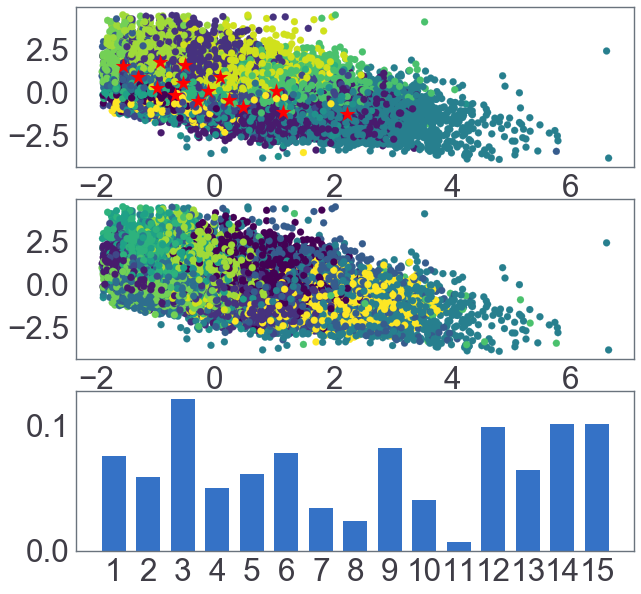

In [8]:
X = data_for_manifoldlearning

# RobustScaler uses [0.25, 0.75] samples
sc=preprocessing.StandardScaler()
#sc=preprocessing.RobustScaler()
sc.fit(X)
X_norm=sc.transform(X)

plt.figure(figsize=(10,10))
x=X_norm[:,0]
y=X_norm[:,1]

#Execute the K-means
km=cluster.KMeans(n_clusters=15)
z_km=km.fit(X_norm)

# Plot the K-means result
plt.subplot(311)
plt.scatter(x,y, c=z_km.labels_)
plt.scatter(z_km.cluster_centers_[:,0],z_km.cluster_centers_[:,1],s=250, marker='*',c='red')

# Execute the VBGMM
vbgm = mixture.BayesianGaussianMixture(n_components=15, covariance_type='full', max_iter=1000, verbose=1)
vbgm=vbgm.fit(X_norm)
labels=vbgm.predict(X_norm)

# Plot the VBGMM result
plt.subplot(312)
plt.scatter(x,y, c=labels)

# Plot the probability distribution calculated by VBGMM
#print(vbgm.weights_)
plt.subplot(313)
x_tick =np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
plt.bar(x_tick, vbgm.weights_, width=0.7, tick_label=x_tick)

In [9]:
# Add the label from VBGMM to the original pd.DataFrame
data_for_manifoldlearning = data_for_manifoldlearning.join(pd.DataFrame(labels, index=data_for_manifoldlearning.index, columns=['label']))
DATA_GAMA_FLUX = DATA_GAMA_FLUX.join(pd.DataFrame(labels, index=data_for_manifoldlearning.index, columns=['label']))

In [10]:
'''
# How many clusters are the best for K-means?
distortions = []

for i in tnrange(1,15):
    km = cluster.KMeans(n_clusters=i,
                        init='k-means++',
                        n_init=10,
                        max_iter=300)
    km.fit(X)
    distortions.append(km.inertia_)

plt.plot(range(1,15),distortions,marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()
'''

"\n# How many clusters are the best for K-means?\ndistortions = []\n\nfor i in tnrange(1,15):\n    km = cluster.KMeans(n_clusters=i,\n                        init='k-means++',\n                        n_init=10,\n                        max_iter=300)\n    km.fit(X)\n    distortions.append(km.inertia_)\n\nplt.plot(range(1,15),distortions,marker='o')\nplt.xlabel('Number of clusters')\nplt.ylabel('Distortion')\nplt.show()\n"

label:0, center_point=(0.9935821018035174, 4.626308676870717)
# of samples : 5512
label:1, center_point=(0.23974691882813523, 1.9139693519742353)
# of samples : 4280
label:2, center_point=(0.9278807461575344, 2.9469898061454205)
# of samples : 9377
label:3, center_point=(0.2506156777754404, 1.846386877216944)
# of samples : 3491
label:4, center_point=(1.0615922322586835, 3.2533762878280394)
# of samples : 4158
label:5, center_point=(0.9217781597234181, 3.204697542037385)
# of samples : 5975
label:6, center_point=(0.7217958675721532, 3.301548547800357)
# of samples : 2302
label:7, center_point=(0.8408268197848848, 3.5259808166440503)
# of samples : 1584
label:8, center_point=(1.0073564387432177, 3.5544613065136716)
# of samples : 5980
label:9, center_point=(0.9547603487157802, 4.944264256745686)
# of samples : 3004
label:10, center_point=(0.22544082593243658, 2.420140512189213)
# of samples : 512
label:11, center_point=(0.5655053191990576, 2.342853367404624)
# of samples : 7570
label:12

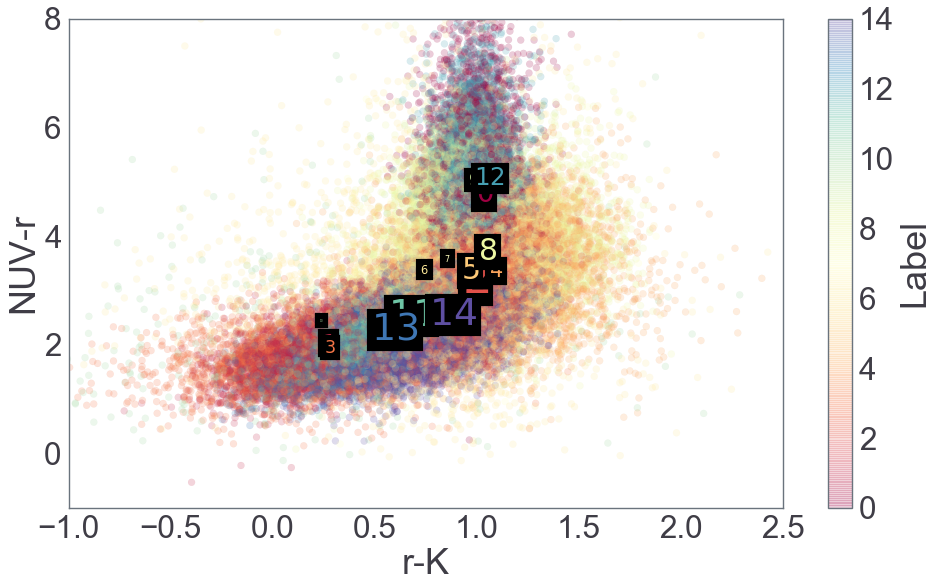

In [11]:
# Show the color-color plot with labels (each number on the plot shows the label number)

plt.figure(figsize=(16, 9))
x = DATA_GAMA_FLUX['R-K']
y = DATA_GAMA_FLUX['NUV-R']
plt.scatter(x, y, c=DATA_GAMA_FLUX['label'], alpha=0.2, cmap=plt.cm.Spectral)
cbar = plt.colorbar()  
cbar.set_label('Label')
plt.clim(vmin=0, vmax=14)
plt.xlabel('r-K')
plt.xlim([-1, 2.5])
plt.ylabel('NUV-r')
plt.ylim([-1, 8])

for i in tnrange(15):
    x_mean = np.mean(DATA_GAMA_FLUX.loc[DATA_GAMA_FLUX['label'] == i, 'R-K'])
    y_mean = np.mean(DATA_GAMA_FLUX.loc[DATA_GAMA_FLUX['label'] == i, 'NUV-R'])
    print('label:%s, center_point=(%s, %s)'%(i, x_mean, y_mean))
    print('# of samples : %s'%(len(DATA_GAMA_FLUX.loc[DATA_GAMA_FLUX['label'] == i])))
    plt.text(x_mean, y_mean, '$%s$'%(i), fontweight='heavy', backgroundcolor='black', fontsize=len(DATA_GAMA_FLUX.loc[DATA_GAMA_FLUX['label'] == i])/200, color=plt.cm.Spectral(i/14))
    

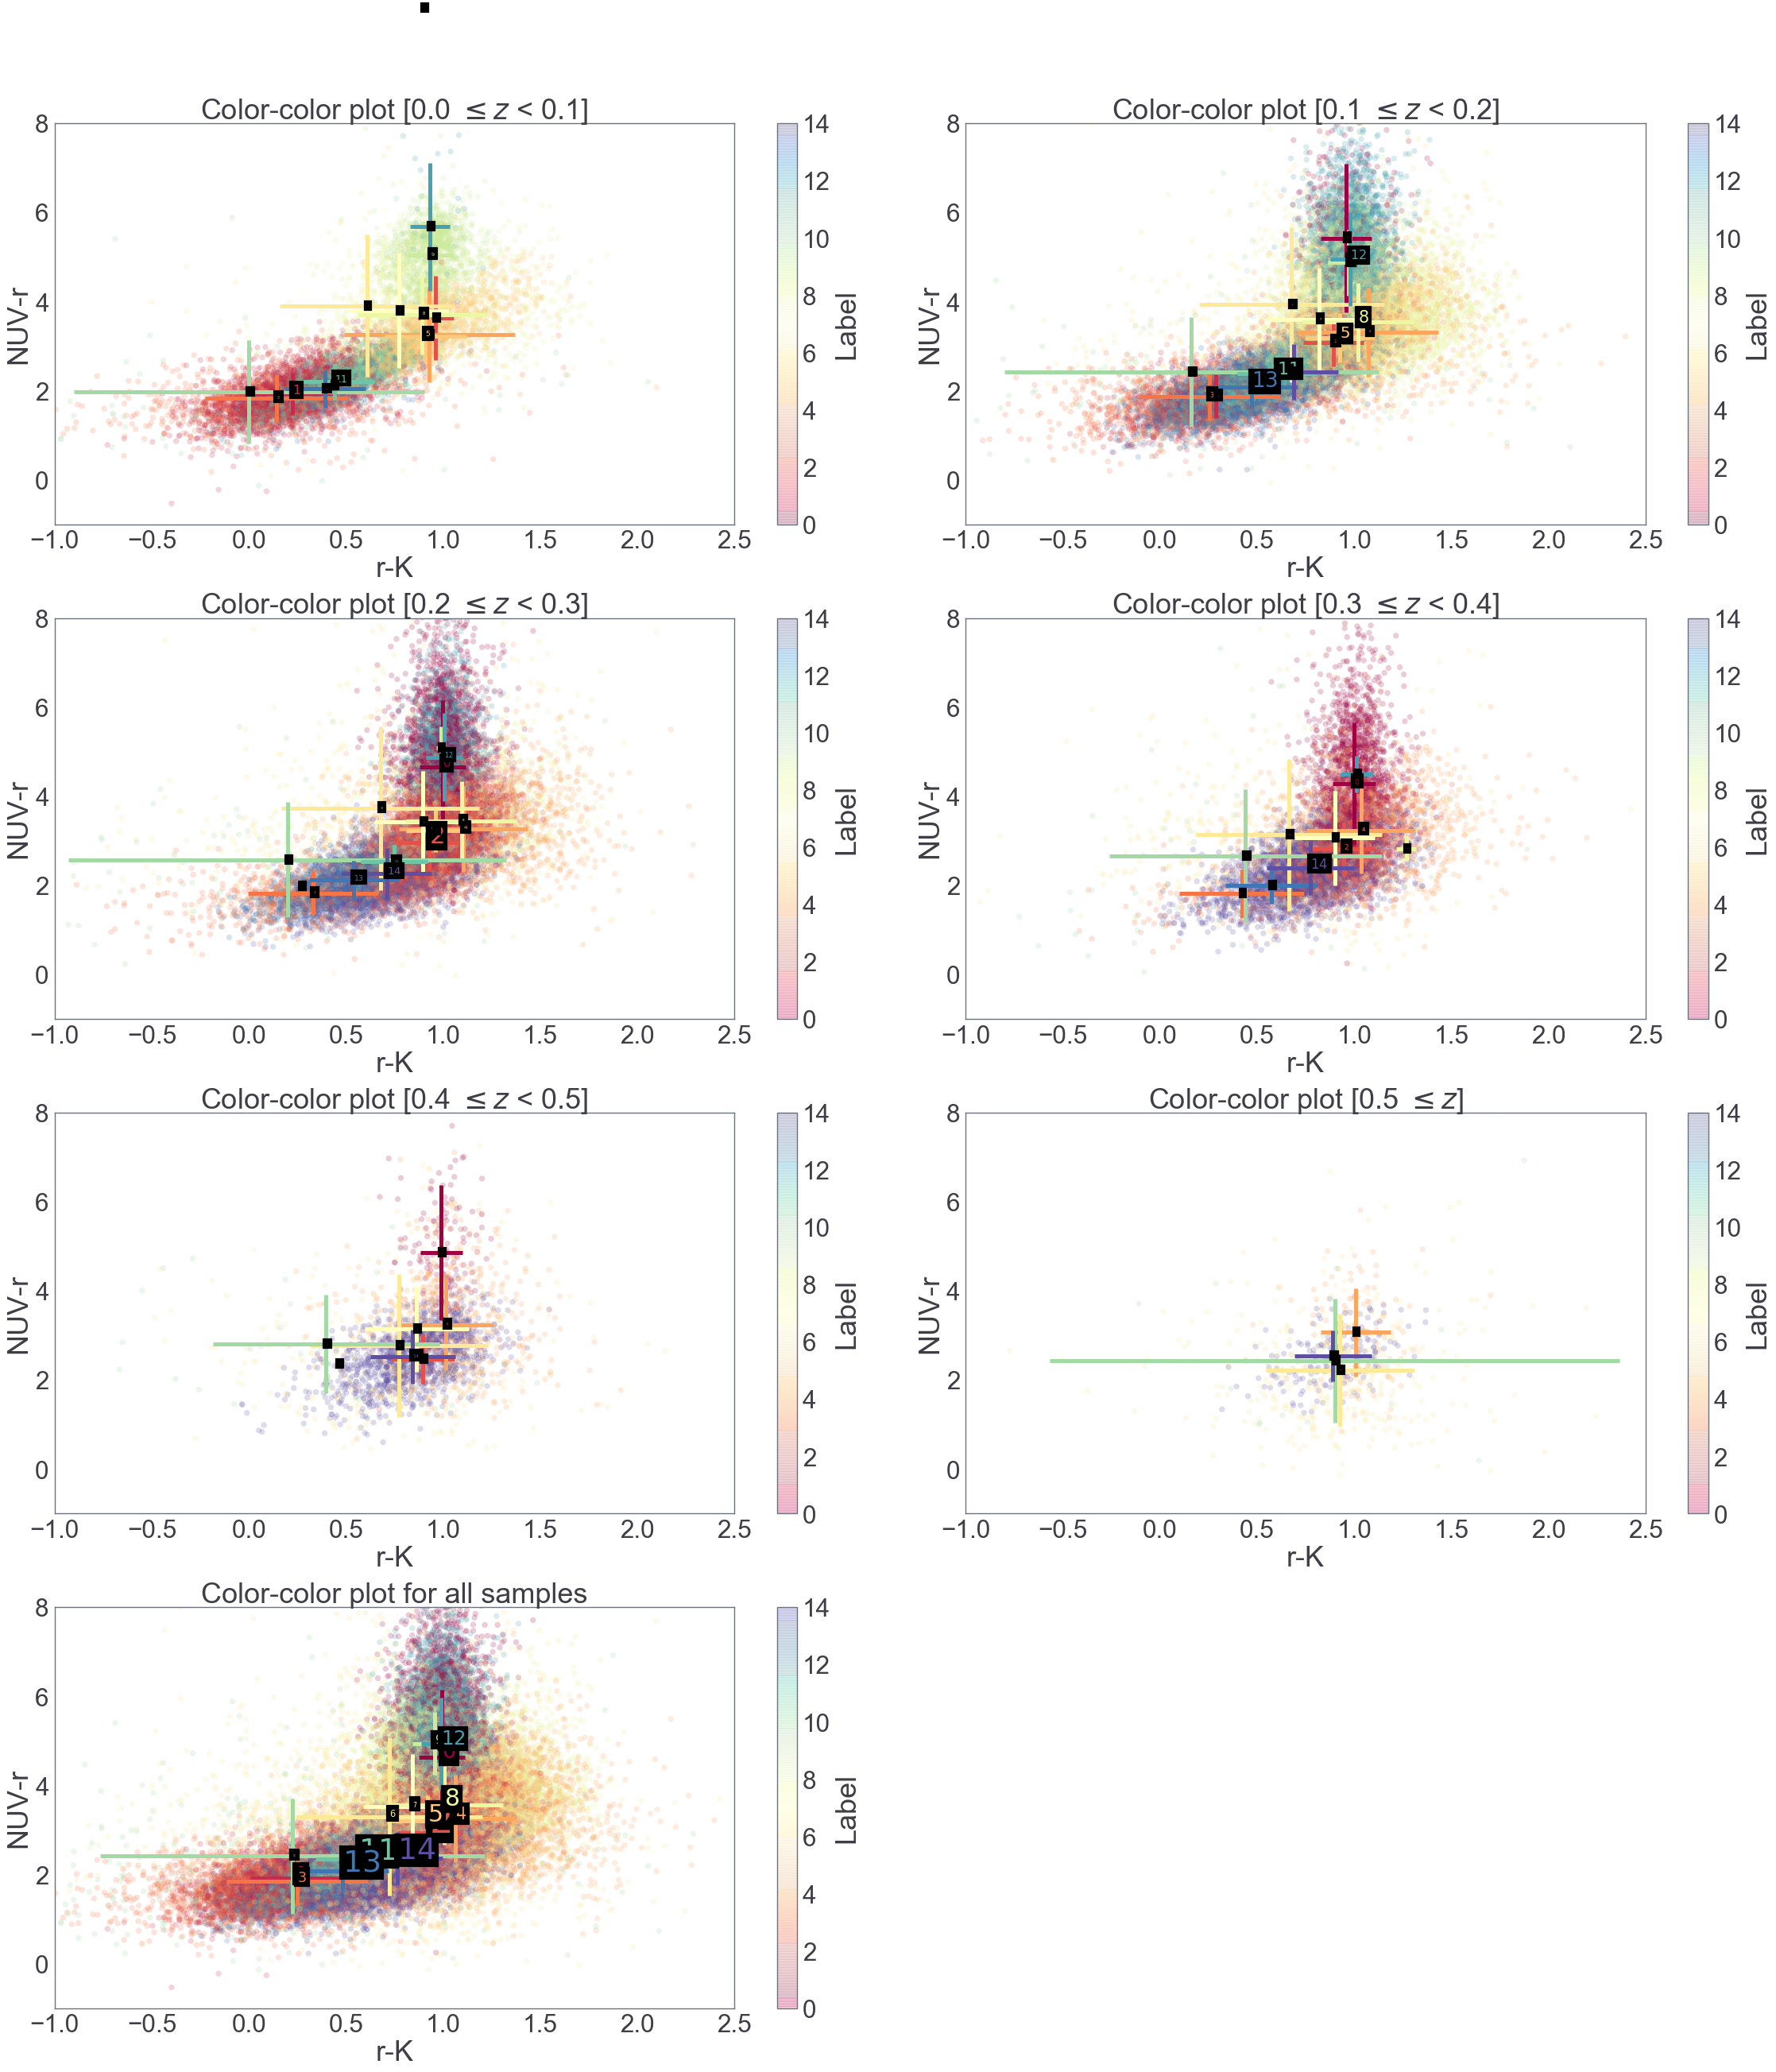

In [12]:
#  Color-color plot with colorbars based on redshift
plt.figure(figsize=(32, 36))
for i in tnrange(6):
    if i <= 4:
        plt.subplot(421 + i)
        z_range = (DATA_GAMA_FLUX['Z_TONRY'] >= 0.1 * i) & (DATA_GAMA_FLUX['Z_TONRY'] < (0.1 * i) + 0.1)
        x = DATA_GAMA_FLUX['R-K'].loc[z_range]
        y = DATA_GAMA_FLUX['NUV-R'].loc[z_range]
        c_z = DATA_GAMA_FLUX['label'].loc[z_range]
        plt.scatter(x, y, c=c_z, alpha=0.2, cmap=plt.cm.Spectral)
        cbar = plt.colorbar()  
        cbar.set_label('Label')
        plt.clim(vmin=0, vmax=14)
        plt.xlabel('r-K')
        plt.xlim([-1, 2.5])
        plt.ylabel('NUV-r')
        plt.ylim([-1, 8])
        plt.title(r'Color-color plot [%s $\leq z$ < %s]'%('{:.1f}'.format((0.1 * i)), '{:.1f}'.format((0.1 * i) + 0.1)))
        for j in range(15):
            x_mean = np.mean(DATA_GAMA_FLUX.loc[z_range & (DATA_GAMA_FLUX['label'] == j), 'R-K'])
            x_std = np.std(DATA_GAMA_FLUX.loc[z_range & (DATA_GAMA_FLUX['label'] == j), 'R-K'])
            y_mean = np.mean(DATA_GAMA_FLUX.loc[z_range & (DATA_GAMA_FLUX['label'] == j), 'NUV-R'])
            y_std = np.std(DATA_GAMA_FLUX.loc[z_range & (DATA_GAMA_FLUX['label'] == j), 'NUV-R'])
            #print('label:%s, center_point=(%s, %s)'%(j, x_mean, y_mean))
            #print('# of samples : %s'%(len(DATA_GAMA_FLUX.loc[z_range & (DATA_GAMA_FLUX['label'] == j)])))
            if not np.isnan(x_mean):
                plt.text(x_mean, y_mean, '$%s$'%(j), fontweight='heavy', backgroundcolor='black', fontsize=len(DATA_GAMA_FLUX.loc[z_range & (DATA_GAMA_FLUX['label'] == j)])/200, color=plt.cm.Spectral(j/14))
                plt.errorbar(x_mean, y_mean, xerr=x_std, yerr=y_std, fmt='.', lw=5, ecolor=plt.cm.Spectral(j/14))
    else:
        plt.subplot(421 + i)
        z_range = (DATA_GAMA_FLUX['Z_TONRY'] >= 0.1 * i)
        x = DATA_GAMA_FLUX['R-K'].loc[z_range]
        y = DATA_GAMA_FLUX['NUV-R'].loc[z_range]
        c_z = DATA_GAMA_FLUX['label'].loc[z_range]
        plt.scatter(x, y, c=c_z, alpha=0.2, cmap=plt.cm.Spectral)
        cbar = plt.colorbar()  
        cbar.set_label('Label')
        plt.clim(vmin=0, vmax=14)
        plt.xlabel('r-K')
        plt.xlim([-1, 2.5])
        plt.ylabel('NUV-r')
        plt.ylim([-1, 8])
        plt.title(r'Color-color plot [%s $\leq z$]'%('{:.1f}'.format(0.1 * i)))
        for j in range(15):
            x_mean = np.mean(DATA_GAMA_FLUX.loc[z_range & (DATA_GAMA_FLUX['label'] == j), 'R-K'])
            x_std = np.std(DATA_GAMA_FLUX.loc[z_range & (DATA_GAMA_FLUX['label'] == j), 'R-K'])
            y_mean = np.mean(DATA_GAMA_FLUX.loc[z_range & (DATA_GAMA_FLUX['label'] == j), 'NUV-R'])
            y_std = np.std(DATA_GAMA_FLUX.loc[z_range & (DATA_GAMA_FLUX['label'] == j), 'NUV-R'])
            #print('label:%s, center_point=(%s, %s)'%(j, x_mean, y_mean))
            #print('# of samples : %s'%(len(DATA_GAMA_FLUX.loc[z_range & (DATA_GAMA_FLUX['label'] == j)])))
            if not np.isnan(x_mean):
                plt.text(x_mean, y_mean, '$%s$'%(j), fontweight='heavy', backgroundcolor='black', fontsize=len(DATA_GAMA_FLUX.loc[z_range & (DATA_GAMA_FLUX['label'] == j)])/200, color=plt.cm.Spectral(j/14))
                plt.errorbar(x_mean, y_mean, xerr=x_std, yerr=y_std, fmt='.', lw=5, ecolor=plt.cm.Spectral(j/14))
plt.subplot(427)
x = DATA_GAMA_FLUX['R-K']
y = DATA_GAMA_FLUX['NUV-R']
plt.scatter(x, y, c=DATA_GAMA_FLUX['label'], alpha=0.2, cmap=plt.cm.Spectral)
cbar = plt.colorbar()  
cbar.set_label('Label')
plt.clim(vmin=0, vmax=14)
plt.xlabel('r-K')
plt.xlim([-1, 2.5])
plt.ylabel('NUV-r')
plt.ylim([-1, 8])
plt.title('Color-color plot for all samples')
for j in range(15):
    x_mean = np.mean(DATA_GAMA_FLUX.loc[(DATA_GAMA_FLUX['label'] == j), 'R-K'])
    x_std = np.std(DATA_GAMA_FLUX.loc[(DATA_GAMA_FLUX['label'] == j), 'R-K'])
    y_mean = np.mean(DATA_GAMA_FLUX.loc[(DATA_GAMA_FLUX['label'] == j), 'NUV-R'])
    y_std = np.std(DATA_GAMA_FLUX.loc[(DATA_GAMA_FLUX['label'] == j), 'NUV-R'])
    #print('label:%s, center_point=(%s, %s)'%(j, x_mean, y_mean))
    #print('# of samples : %s'%(len(DATA_GAMA_FLUX.loc[z_range & (DATA_GAMA_FLUX['label'] == j)])))
    if not np.isnan(x_mean):
        plt.text(x_mean, y_mean, '$%s$'%(j), fontweight='heavy', backgroundcolor='black', fontsize=len(DATA_GAMA_FLUX.loc[(DATA_GAMA_FLUX['label'] == j)])/200, color=plt.cm.Spectral(j/14))
        plt.errorbar(x_mean, y_mean, xerr=x_std, yerr=y_std, fmt='.', lw=5, ecolor=plt.cm.Spectral(j/14))
plt.tight_layout()

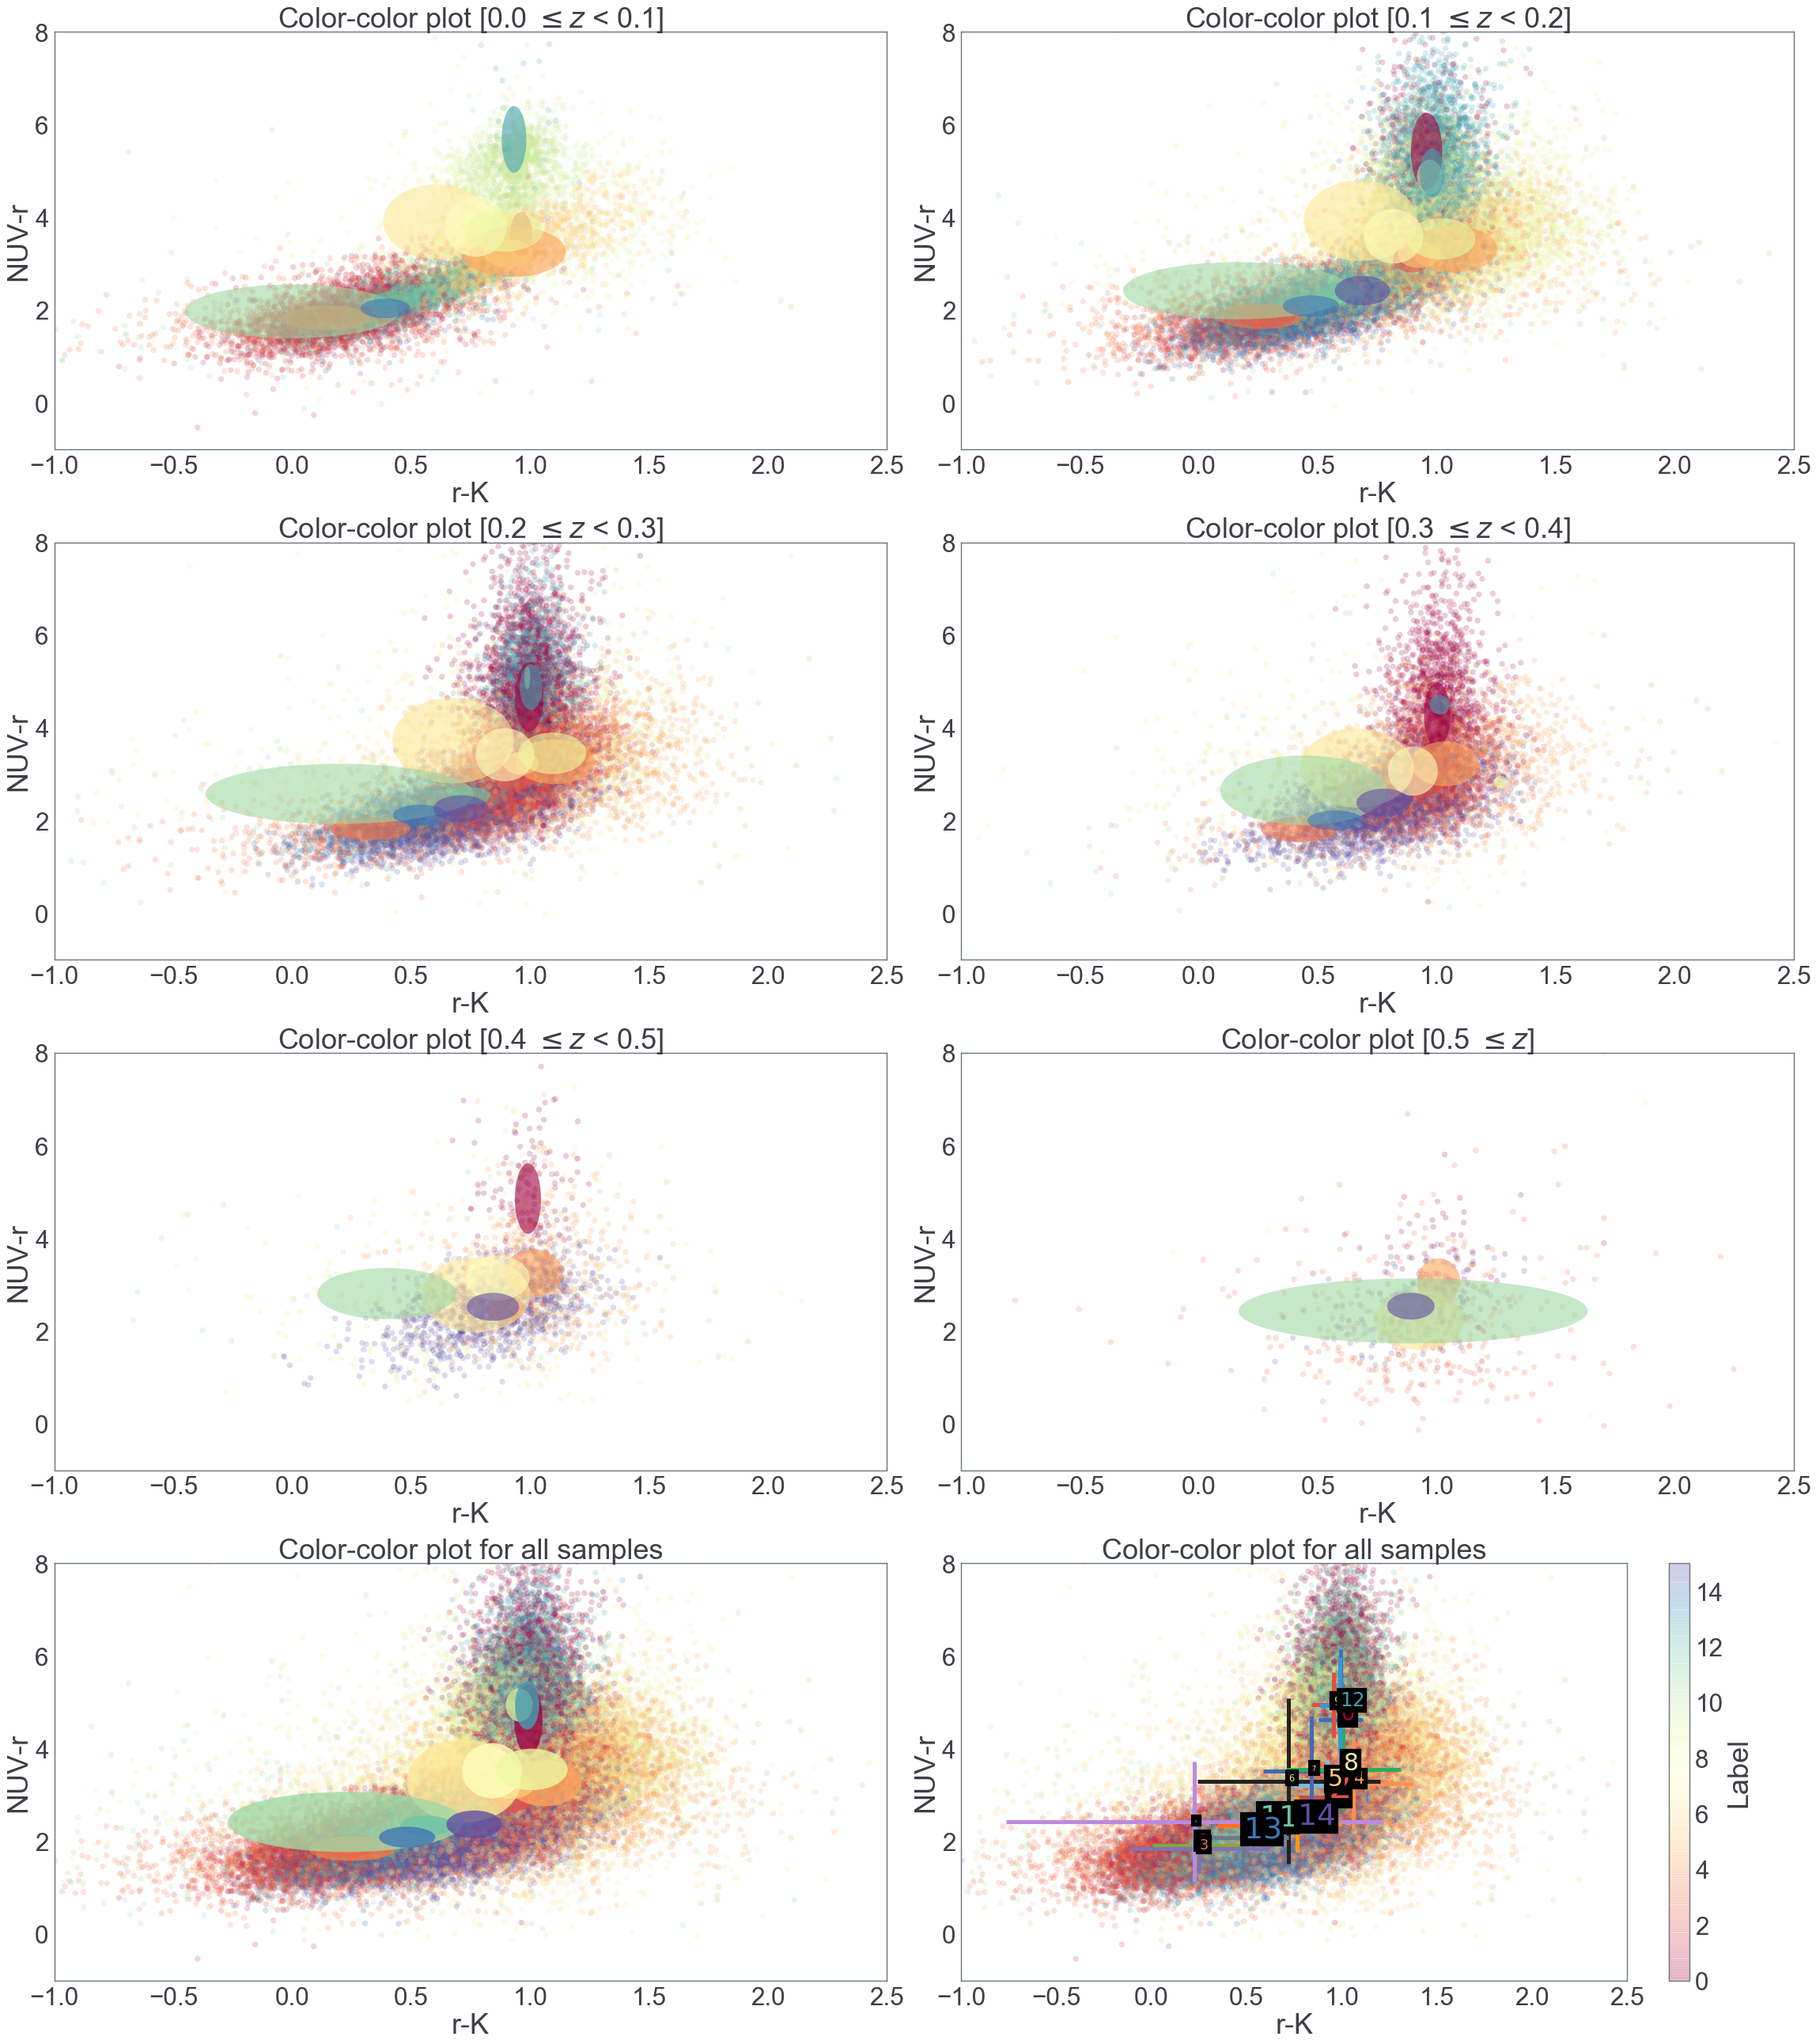

In [13]:
#  Color-color plot with colorbars based on redshift
fig = plt.figure(figsize=(32, 36))
for i in tnrange(6):
    if i <= 4:
        ax = fig.add_subplot(421+i)
        z_range = (DATA_GAMA_FLUX['Z_TONRY'] >= 0.1 * i) & (DATA_GAMA_FLUX['Z_TONRY'] < (0.1 * i) + 0.1)
        x = DATA_GAMA_FLUX['R-K'].loc[z_range]
        y = DATA_GAMA_FLUX['NUV-R'].loc[z_range]
        c_z = DATA_GAMA_FLUX['label'].loc[z_range]
        ax.scatter(x, y, c=c_z, alpha=0.2, cmap=plt.cm.Spectral)
        ax.set_xlabel('r-K')
        ax.set_xlim([-1, 2.5])
        ax.set_ylabel('NUV-r')
        ax.set_ylim([-1, 8])
        ax.set_title(r'Color-color plot [%s $\leq z$ < %s]'%('{:.1f}'.format((0.1 * i)), '{:.1f}'.format((0.1 * i) + 0.1)))
        for j in range(15):
            x_mean = np.mean(DATA_GAMA_FLUX.loc[z_range & (DATA_GAMA_FLUX['label'] == j), 'R-K'])
            x_std = np.std(DATA_GAMA_FLUX.loc[z_range & (DATA_GAMA_FLUX['label'] == j), 'R-K'])
            y_mean = np.mean(DATA_GAMA_FLUX.loc[z_range & (DATA_GAMA_FLUX['label'] == j), 'NUV-R'])
            y_std = np.std(DATA_GAMA_FLUX.loc[z_range & (DATA_GAMA_FLUX['label'] == j), 'NUV-R'])
            #print('label:%s, center_point=(%s, %s)'%(j, x_mean, y_mean))
            #print('# of samples : %s'%(len(DATA_GAMA_FLUX.loc[z_range & (DATA_GAMA_FLUX['label'] == j)])))
            if not np.isnan(x_mean):
                e1 =pat.Ellipse(xy = (x_mean, y_mean), width = x_std, height = y_std, alpha = 0.6, angle = 0, color =plt.cm.Spectral(j/14))
                ax.add_patch(e1)
    else:
        ax = fig.add_subplot(421+i)
        z_range = (DATA_GAMA_FLUX['Z_TONRY'] >= 0.1 * i)
        x = DATA_GAMA_FLUX['R-K'].loc[z_range]
        y = DATA_GAMA_FLUX['NUV-R'].loc[z_range]
        c_z = DATA_GAMA_FLUX['label'].loc[z_range]
        ax.scatter(x, y, c=c_z, alpha=0.2, cmap=plt.cm.Spectral)
        ax.set_xlabel('r-K')
        ax.set_xlim([-1, 2.5])
        ax.set_ylabel('NUV-r')
        ax.set_ylim([-1, 8])
        ax.set_title(r'Color-color plot [%s $\leq z$]'%('{:.1f}'.format(0.1 * i)))
        for j in range(15):
            x_mean = np.mean(DATA_GAMA_FLUX.loc[z_range & (DATA_GAMA_FLUX['label'] == j), 'R-K'])
            x_std = np.std(DATA_GAMA_FLUX.loc[z_range & (DATA_GAMA_FLUX['label'] == j), 'R-K'])
            y_mean = np.mean(DATA_GAMA_FLUX.loc[z_range & (DATA_GAMA_FLUX['label'] == j), 'NUV-R'])
            y_std = np.std(DATA_GAMA_FLUX.loc[z_range & (DATA_GAMA_FLUX['label'] == j), 'NUV-R'])
            #print('label:%s, center_point=(%s, %s)'%(j, x_mean, y_mean))
            #print('# of samples : %s'%(len(DATA_GAMA_FLUX.loc[z_range & (DATA_GAMA_FLUX['label'] == j)])))
            if not np.isnan(x_mean):
                e1 =pat.Ellipse(xy = (x_mean, y_mean), width = x_std, height = y_std, alpha = 0.6, angle = 0, color =plt.cm.Spectral(j/14))
                ax.add_patch(e1)

ax = fig.add_subplot(427)
x = DATA_GAMA_FLUX['R-K']
y = DATA_GAMA_FLUX['NUV-R']
ax.scatter(x, y, c=DATA_GAMA_FLUX['label'], alpha=0.2, cmap=plt.cm.Spectral)
ax.set_xlabel('r-K')
ax.set_xlim([-1, 2.5])
ax.set_ylabel('NUV-r')
ax.set_ylim([-1, 8])
ax.set_title('Color-color plot for all samples')
for j in range(15):
    x_mean = np.mean(DATA_GAMA_FLUX.loc[(DATA_GAMA_FLUX['label'] == j), 'R-K'])
    x_std = np.std(DATA_GAMA_FLUX.loc[(DATA_GAMA_FLUX['label'] == j), 'R-K'])
    y_mean = np.mean(DATA_GAMA_FLUX.loc[(DATA_GAMA_FLUX['label'] == j), 'NUV-R'])
    y_std = np.std(DATA_GAMA_FLUX.loc[(DATA_GAMA_FLUX['label'] == j), 'NUV-R'])
    if not np.isnan(x_mean):
        e1 =pat.Ellipse(xy = (x_mean, y_mean), width = x_std, height = y_std, alpha = 0.8, angle = 0, color =plt.cm.Spectral(j/14))
        ax.add_patch(e1)
        
plt.subplot(428)
x = DATA_GAMA_FLUX['R-K']
y = DATA_GAMA_FLUX['NUV-R']
plt.scatter(x, y, c=DATA_GAMA_FLUX['label'], alpha=0.2, cmap=plt.cm.Spectral)
cbar = plt.colorbar()  
cbar.set_label('Label')
plt.clim(vmin=0, vmax=15)
plt.xlabel('r-K')
plt.xlim([-1, 2.5])
plt.ylabel('NUV-r')
plt.ylim([-1, 8])
plt.title('Color-color plot for all samples')
for j in range(15):
    x_mean = np.mean(DATA_GAMA_FLUX.loc[(DATA_GAMA_FLUX['label'] == j), 'R-K'])
    x_std = np.std(DATA_GAMA_FLUX.loc[(DATA_GAMA_FLUX['label'] == j), 'R-K'])
    y_mean = np.mean(DATA_GAMA_FLUX.loc[(DATA_GAMA_FLUX['label'] == j), 'NUV-R'])
    y_std = np.std(DATA_GAMA_FLUX.loc[(DATA_GAMA_FLUX['label'] == j), 'NUV-R'])
    #print('label:%s, center_point=(%s, %s)'%(j, x_mean, y_mean))
    #print('# of samples : %s'%(len(DATA_GAMA_FLUX.loc[z_range & (DATA_GAMA_FLUX['label'] == j)])))
    if not np.isnan(x_mean):
        plt.text(x_mean, y_mean, '$%s$'%(j), fontweight='heavy', backgroundcolor='black', fontsize=len(DATA_GAMA_FLUX.loc[(DATA_GAMA_FLUX['label'] == j)])/200, color=plt.cm.Spectral(j/14))
        plt.errorbar(x_mean, y_mean, xerr=x_std, yerr=y_std, fmt='.', lw=5)
plt.tight_layout()

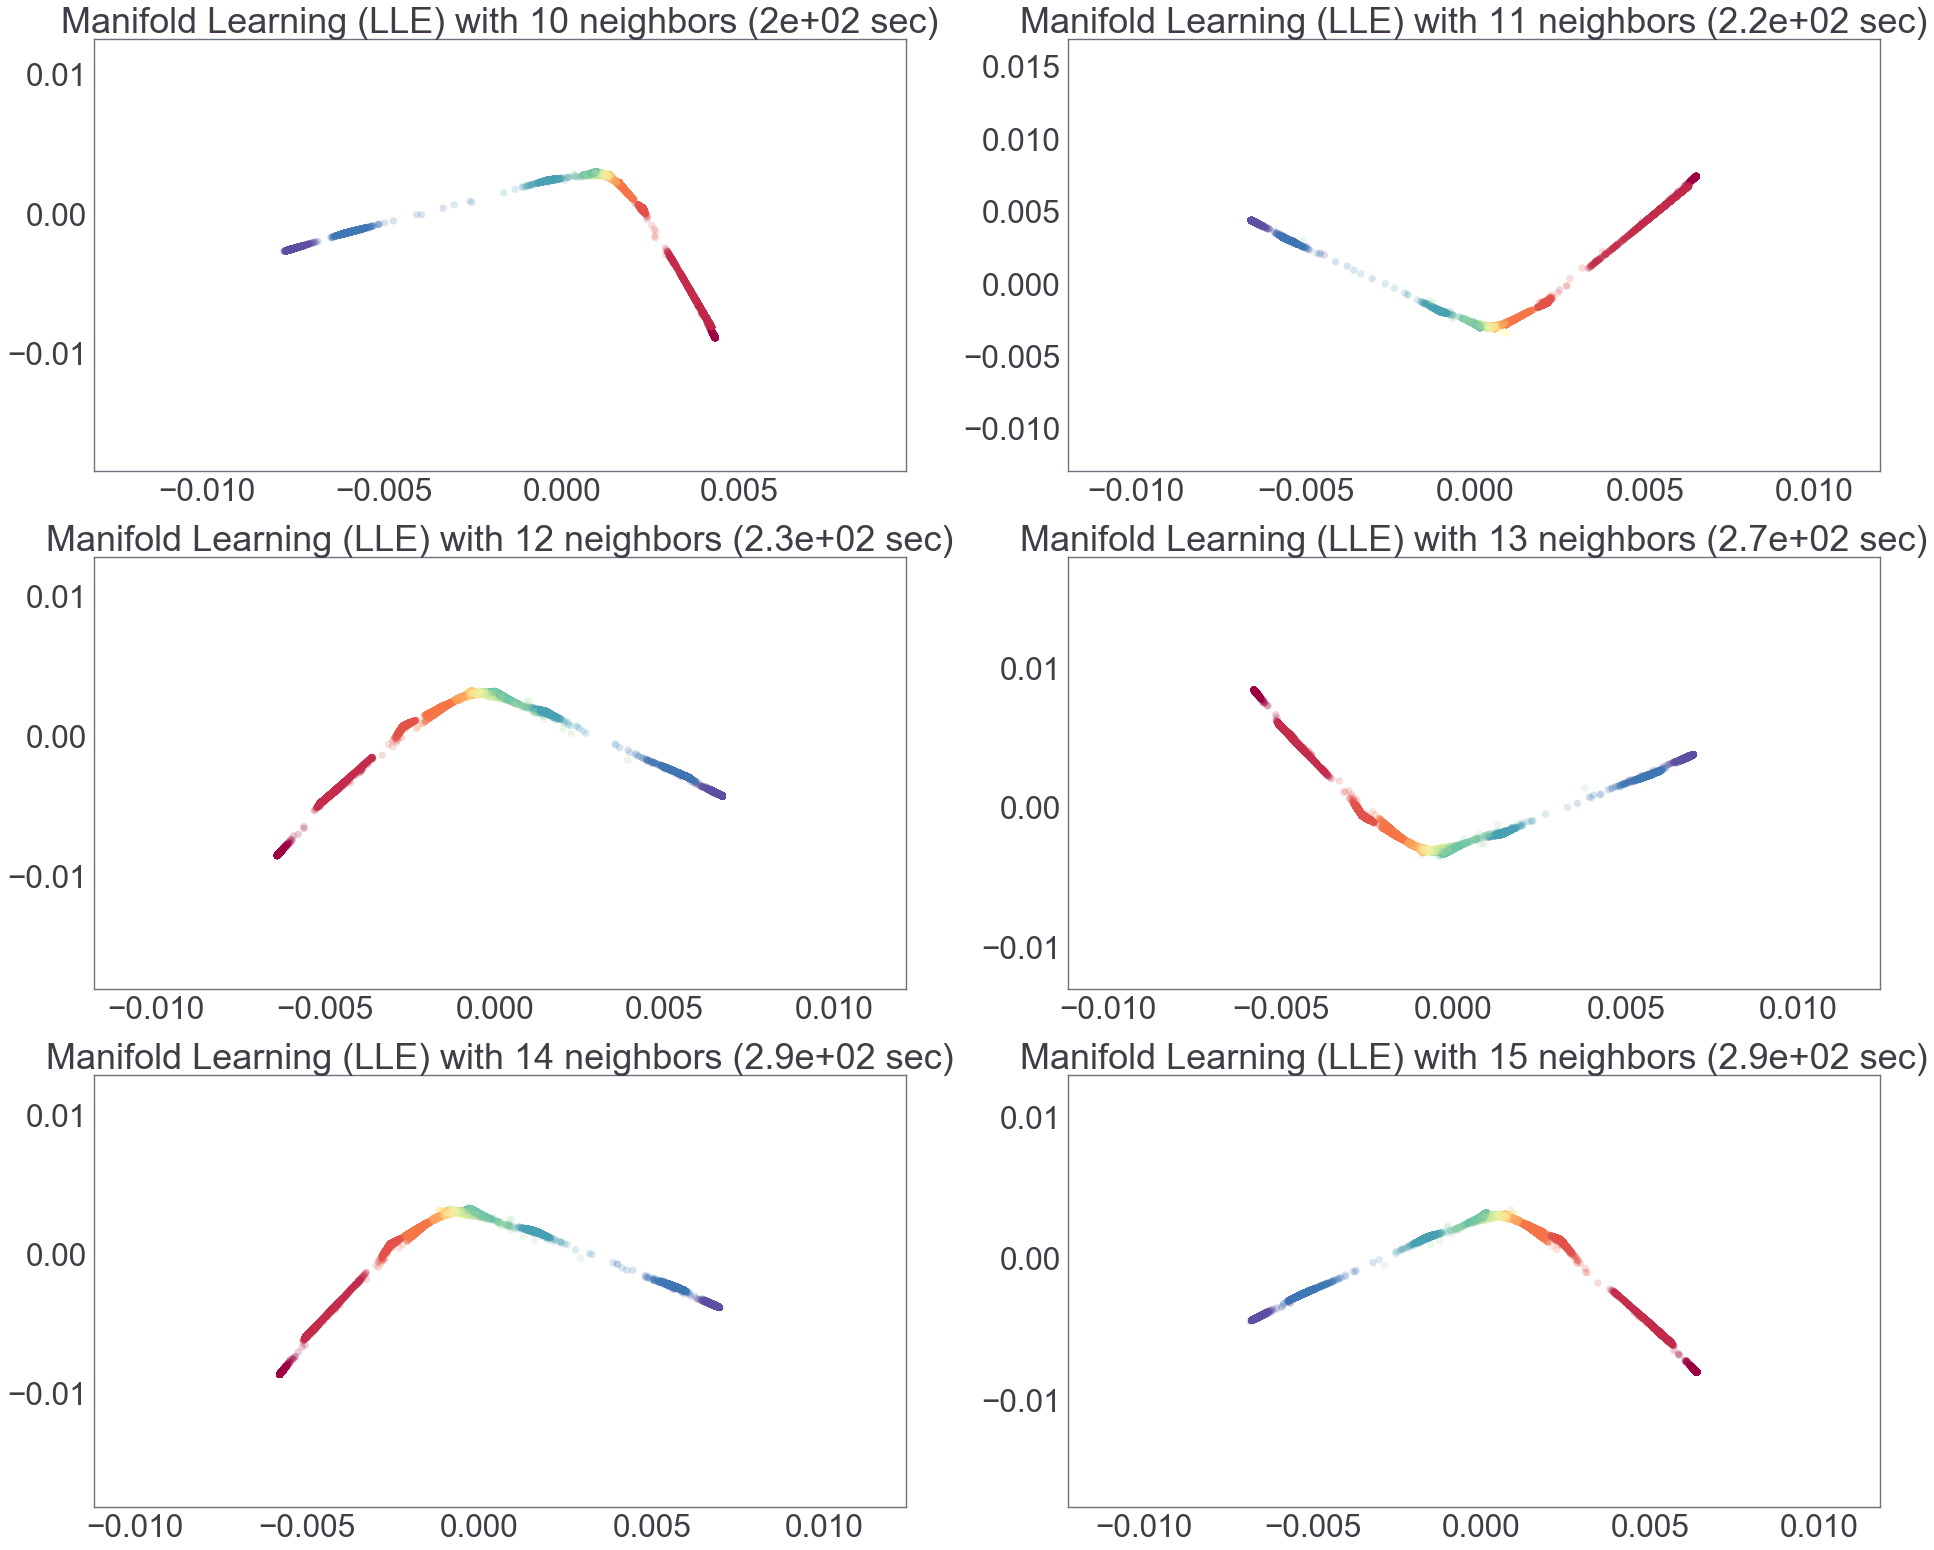

In [14]:
n_components = 2
nparray_data_for_manifoldlearning = data_for_manifoldlearning.values
X = nparray_data_for_manifoldlearning
fig = plt.figure(figsize=(32, 27))

for i in tnrange(6):
    n_neighbors = i+10
    
    t0 = time()
    Y = manifold.LocallyLinearEmbedding(n_neighbors, n_components,
                                        eigen_solver='auto',
                                        method='modified').fit_transform(X)
    t1 = time()
    ax = fig.add_subplot(321+i)
    ax.scatter(Y[:, 0], Y[:, 1], alpha=0.2, c=data_for_manifoldlearning['label'], cmap=plt.cm.Spectral)
    ax.set_title("Manifold Learning (LLE) with %i neighbors (%.2g sec)" % (n_neighbors, t1 - t0))

In [15]:
for kind in tqdm_notebook(['tied', 'diag', 'spherical', 'full']):
    time_start = time()
    vbgm = mixture.BayesianGaussianMixture(n_components=15, covariance_type=kind, max_iter=1000, verbose=1)
    vbgm=vbgm.fit(X_norm)
    labels=vbgm.predict(X_norm)
    print('%s : score = %s'%(kind, vbgm.score(X_norm)))

Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
  Iteration 70
  Iteration 80
  Iteration 90
  Iteration 100
  Iteration 110
  Iteration 120
  Iteration 130
  Iteration 140
  Iteration 150
  Iteration 160
  Iteration 170
  Iteration 180
  Iteration 190
  Iteration 200
  Iteration 210
  Iteration 220
  Iteration 230
  Iteration 240
  Iteration 250
  Iteration 260
  Iteration 270
  Iteration 280
Initialization converged: True
tied : score = 3.660897099918509
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
  Iteration 70
  Iteration 80
  Iteration 90
  Iteration 100
  Iteration 110
  Iteration 120
  Iteration 130
  Iteration 140
  Iteration 150
  Iteration 160
  Iteration 170
  Iteration 180
  Iteration 190
  Iteration 200
  Iteration 210
  Iteration 220
  Iteration 230
  Iteration 240
  Iteration 250
  Iteration 260
  Iteration 270
Initialization converged: True
diag : sc

In [16]:
for n_comp in tnrange(1, 16):
    time_start = time()
    vbgm = mixture.BayesianGaussianMixture(n_components=n_comp, covariance_type='full', max_iter=1000, verbose=1)
    vbgm=vbgm.fit(X_norm)
    labels=vbgm.predict(X_norm)
    print('%s_component : score = %s'%(n_comp, vbgm.score(X_norm)))

Initialization 0
Initialization converged: True
1_component : score = 2.4455779463676075
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
2_component : score = 4.426256648309006
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
  Iteration 70
  Iteration 80
Initialization converged: True
3_component : score = 5.250565214812397
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
  Iteration 70
  Iteration 80
Initialization converged: True
4_component : score = 5.688847474229358
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
  Iteration 70
  Iteration 80
  Iteration 90
Initialization converged: True
5_component : score = 5.9613275733098
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
  Iteration 70
  Iteration 80
  It